### Реализация нейронной сети

В этом блоке обучим полносвязную нейронную сеть распознавать рукописные цифры, самостоятельно реализовав все составляющие алгоритма обучения и предсказания.

Для реализации модели воспользуемся фреймворком **Pytorch**. Стандартным подходом при реализации нейросетевых моделей является её декомпозиция на отдельные блоки. С помощью данной библиотеки можно создавать как модели из готовых блоков-слоёв, так и реализовывать свои модули. При этом Pytorch скрывает все сложности, связанные с вычислениями выходов модели по её входам и подсчётом градиентов, что делает эту библиотеку особенно удобной при использовании *Градиентных методов оптимизации*, таких как **Стохастический Градиентный Спуск (SGD)**, **LBFGS** и других. 

In [1]:
import torch

import numpy as np

Рассмотрим простейший пример модуля, который реализует **Тождественное преобразование**:

In [2]:
class Identity(torch.nn.Module):
    def __init__(self):
        # Необходимо вызвать конструктор базового класса для корректной работы блока
        super().__init__()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Функция, реализующая прямой проход через слой. В процессе вычислений создаётся граф вычислений
            сквозь который выполняется автоматическое дифференцирование.
        '''
        return x
    
    def __repr__(self):

        return 'Identity()'

Создадим экземпляр данного слоя и проверим его работу:

In [3]:
identity_layer = Identity()
x = torch.randn([3, 5])

# метод __call__ был автоматически переопределён через вызов метода forward
print(x, identity_layer(x), sep='\n')
print(identity_layer, torch.equal(x, identity_layer(x)))

tensor([[ 1.4175,  0.8315,  1.5518, -1.6783, -0.4060],
        [-0.4235, -0.6578,  1.9966,  0.5924, -0.0261],
        [ 0.3223, -0.4988, -1.3283,  0.5820,  0.0116]])
tensor([[ 1.4175,  0.8315,  1.5518, -1.6783, -0.4060],
        [-0.4235, -0.6578,  1.9966,  0.5924, -0.0261],
        [ 0.3223, -0.4988, -1.3283,  0.5820,  0.0116]])
Identity() True


### Слой нелинейности ReLU

Теперь реализуем слой нелинейности $\text{ReLU}(y) = \max(0, y)$. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения $\text{ReLU}$ к входному массиву.

In [4]:
class ReLU(torch.nn.Module):
    def __init__(self):
        '''
        Слой ReLU поэлементно применяет rectified linear unit к своему входу
        '''
        super().__init__()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Применяет ReLU ко входному тензору
        '''
        return torch.maximum(x, torch.zeros_like(x))

In [5]:
relu_layer = ReLU()
x = torch.randn([3, 5])

assert not torch.any(relu_layer(x) < 0)
assert torch.all(torch.eq(relu_layer(x), torch.nn.ReLU()(x)))

print(x, relu_layer(x), sep='\n')
print(relu_layer)

tensor([[ 0.2404, -3.0205, -0.3688, -0.6817,  0.1443],
        [ 0.7374, -1.0377,  0.4602,  0.2372,  0.6118],
        [-1.3664, -2.6385,  1.8878, -0.5152,  0.5457]])
tensor([[0.2404, 0.0000, 0.0000, 0.0000, 0.1443],
        [0.7374, 0.0000, 0.4602, 0.2372, 0.6118],
        [0.0000, 0.0000, 1.8878, 0.0000, 0.5457]])
ReLU()


### Полносвязный слой

Далее реализуем полносвязный слой без нелинейности `Linear`. У слоя два параметра: **матрица весов** и **вектор сдвига**. 

Если параметры/буферы/подмодули зарегистрированы в модуле, то базовый класс позволяет удобно работать с этими сущностями. Рассмотрим основные методы:
* `parameters` — возвращает итератор по всем параметрам, зарегистрированным в данном модуле и всех его подмодулях
* `named_parameters` — возвращает итератор по всем параметрам и их именам, зарегистрированным в данном модуле и всех его подмодулях
* `buffers`/`named_buffers` — аналогичные функции для получения доступа к списку всех буферов
* `requires_grad_(requires_grad=True)` — in-place метод, включающий или выключающий подсчёт градиентов для параметров
* `to(device, dtype)` — изменение типа параметров и устройства на котором они располагаются
* `train`/`eval` — рекурсивное переключение режимов работы модулей. Обычно, перед обучением сети необходимо вызвать метод `train`, а перед тестированием (инференсом) — перевести в режим `eval`. Данные методы необходимы для корректной реализации таких методов регуляризации как BatchNorm и Dropout


Реализуем блок линейного слоя в ячейке ниже.

In [6]:
class Linear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        '''
        Полносвязный слой — это слой выполняющий аффинное преобразование f(x) = x W + b
        '''
        super().__init__()

        # Создаем необходимые обучаемые параметры
        self.weight = torch.nn.Parameter(torch.randn(in_features, out_features)) 
        self.bias = torch.nn.Parameter(torch.randn(out_features))
        
        # Выполняем инициализацию весов
        self.reset_parameters()
        
    def reset_parameters(self):
        '''
        Инициализация весов полносвязного слоя из нормального распределения с 
            нулевым средним и стандартным отклонением 0.01
        Вектор-смещение инициализируется нулями
        '''
        torch.nn.init.normal_(self.weight, mean=0, std=0.01)
        torch.nn.init.zeros_(self.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Выполнение аффинного преобразования f(x) = x W + b
        
        :param torch.Tensor x: входная матрица размера [batch_size, in_features]
        :returns: матрица размера [batch_size, out_features]
        '''
        return x @ self.weight + self.bias
    
    def __repr__(self):
        '''
        Опциональный метод для красивого вывода
        '''
        return 'Linear({0:d}, {1:d})'.format(*self.weight.shape)

In [7]:
linear_layer = Linear(3, 5)
x = torch.randn([2, 3])

print(x, linear_layer(x), sep='\n')
print(linear_layer)

tensor([[ 1.1503,  1.8217,  0.0106],
        [-0.0758,  0.0268, -0.7756]])
tensor([[ 0.0211,  0.0058, -0.0092, -0.0257,  0.0200],
        [ 0.0055,  0.0081, -0.0064, -0.0133,  0.0014]], grad_fn=<AddBackward0>)
Linear(3, 5)


Блоки-наследники `torch.nn.Module` автоматически сохраняют информацию о своей структуре: параметрах, буферах. Например, можно получить генератор всех параметров в данном блоке (метод `parameters`). Более того, каждый параметр имеет своё уникальное имя (обычно оно совпадает с названием переменной, в которую соответствующий параметр был присвоен). Именованный список параметров можно получить через вызов метода `named_parameters`:

In [8]:
linear_layer, list(linear_layer.parameters()), list(linear_layer.named_parameters())

(Linear(3, 5),
 [Parameter containing:
  tensor([[ 7.7475e-03, -6.7751e-03, -1.4975e-02, -5.1236e-05,  6.7737e-03],
          [ 6.7118e-03,  7.5398e-03,  4.3209e-03, -1.4185e-02,  6.7008e-03],
          [-7.6615e-03, -9.5749e-03,  9.8271e-03,  1.6609e-02, -2.2746e-03]],
         requires_grad=True),
  Parameter containing:
  tensor([0., 0., 0., 0., 0.], requires_grad=True)],
 [('weight',
   Parameter containing:
   tensor([[ 7.7475e-03, -6.7751e-03, -1.4975e-02, -5.1236e-05,  6.7737e-03],
           [ 6.7118e-03,  7.5398e-03,  4.3209e-03, -1.4185e-02,  6.7008e-03],
           [-7.6615e-03, -9.5749e-03,  9.8271e-03,  1.6609e-02, -2.2746e-03]],
          requires_grad=True)),
  ('bias',
   Parameter containing:
   tensor([0., 0., 0., 0., 0.], requires_grad=True))])

### Реализация Softmax-слоя и функции потерь

Для решения задачи многоклассовой классификации обычно используют $Softmax$ в качестве нелинейности на последнем слое, чтобы получить вероятности классов для каждого объекта:
$$\hat y = \text{Softmax}(x)  = \left \{\frac {\exp(x^i)}{\sum_{j=1}^K \exp(x^j)} \right \}_{i=1}^K, \quad K - \text{число классов.}$$

Здесь за $x^i$ мы обозначаем $i$-ый признак объекта $x$.

В качестве функции потерь выберем отрицательный логарифм правдоподобия (по-английски: negative log likelihood или NLL)
$$L(y, \hat y) = -\sum_{i=1}^K \mathbb{1}[y = i]\log \hat y^i,$$
где $\mathbb{1}[y = i]$ — индикатор принадлежности $i$-му классу.

NLL совпадает с выражением для [кросс-энтропии](https://ru.wikipedia.org/wiki/Перекрёстная_энтропия) (в качестве первого распределения берем вырожденное распределение в точке $y$, в качестве второго — предсказанное распределение $\hat y$). Очевидно, что эту функцию потерь также можно переписать через индексацию, если через $y$ обозначить класс данного объекта:
$$L(y, \hat y) = - \log \hat y_{y}$$

В таком виде ее удобно реализовывать.

Для обучения нейронной сети будем оптимизировать эту функцию потерь по параметрам нейронной сети:

$$ \mathfrak{L} = \frac1N \sum_{i=1}^N L(y_i, \hat y_i) = \frac1N \sum_{i=1}^N L(y_i, \text{NN}_{\theta}(x_i)) \rightarrow \min_{\theta}\,,$$
где за $x_i$ и $y_i$ мы обозначили признаки и таргет $i$-ого объекта обучающей выборки, за $\text{NN}_{\theta}$ мы обозначили нейронную сеть, которая по признакам объекта $x_i$ выдает распределение вероятностей $\hat y_i$, за $\theta$ мы обозначили все веса нейронной сети, а $N$ — это число объектов в обучающей выборке.

Реализуем блок для вычисления кросс-энтропии в ячейке ниже.

In [9]:
from scipy.special import logsumexp

In [10]:
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Применение логсофтмакса к каждой строке, а затем выборка элементов в соответствии с метками истинного класса
        :param torch.Tensor x: Матрица логитов размера [batch_size, n_classes]
        :param torch.Tensor labels: Список меток истинного класса. Размер [batch_size]
        :returns: Кросс-энтропийная функция потерь 
        """
        #return -torch.mean((x - torch.logsumexp(x, dim=1, keepdim=True))[torch.arange(labels.shape[0]), labels])
        dif = x - torch.max(x, 1, keepdim=True)[0]
        pred = dif - (dif).exp().sum(-1).log().unsqueeze(-1) 

        return -pred[range(labels.shape[0]), labels.long()].mean()

In [11]:
cel_layer = CrossEntropyLoss()
x = torch.randn([101, 51])
labels = torch.randint(0, x.shape[1], size=[x.shape[0]])

assert torch.abs(cel_layer(x, labels) - torch.nn.CrossEntropyLoss()(x, labels)) < 1e-6

print(cel_layer, cel_layer(x, labels))

CrossEntropyLoss() tensor(4.4965)


## Сборка нейронной сети

Как и для параметров, существует несколько таких контейнеров:
* `torch.nn.ModuleList` — хранит список модулей
* `torch.nn.ModuleDict` — хранит словарь модулей
* `torch.nn.Sequential` — особый контейнер, который хранит список модулей и позволяет последовательно применить модули из списка к объекту, поданному ему на вход

Реализуем простейшую полносвязную нейронную сеть `DenseNetwork`. 

In [12]:
class DenseNetwork(torch.nn.Module):
    def __init__(self, in_features, hidden_size, n_classes, n_layers, activation=ReLU):
        '''
        :param int in_features: Число входных признаков
        :param int hidden_size: Размер скрытых слоёв
        :param int n_classes: Число выходов сети 
        :param int n_layers: Число слоёв в сети
        :param torch.nn.Module activation: Класс функции активации
        '''
        super().__init__()
        #print(n_layers)
        self.layers = torch.nn.Sequential(
            *([Linear(in_features, hidden_size), ReLU()]) +
            [ReLU() if i // 2 else Linear(hidden_size, hidden_size) for i in range(n_layers - 2)] +
            [ReLU(), Linear(hidden_size, n_classes)])
          
        #lst = [Linear(in_features, hidden_size), ReLU()]
        #for i in range(n_layers - 2):
        #    lst += [Linear(hidden_size, hidden_size)]
        #    lst += [ReLU()]
        #lst += [Linear(hidden_size, n_classes), ReLU()]
        #self.layers = torch.nn.Sequential(lst)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Прямой проход по сети
        :param torch.Tensor x: Входной тензор размера [batch_size, in_features]
        :returns: Матрица логитов размера [batch_size, n_classes]
        '''
        return self.layers(x)

Проверем, что наша реализация сети проходит минимальные тесты:

In [13]:
assert sum(buffer.numel() for buffer in DenseNetwork(11, 7, 5, 3).buffers()) == 0
assert sum(param.numel() for param in DenseNetwork(64, 32, 10, 3).parameters()) == 3466

assert list(DenseNetwork(64, 32, 10, 3)(torch.randn([13, 64])).shape) == [13, 10]

In [14]:
in_features = np.prod(8 * 8 * 1)
hidden_size = 32
n_classes = 10

dense_network = DenseNetwork(
    in_features=in_features, hidden_size=hidden_size, 
    n_classes=n_classes, n_layers=3, activation=ReLU
)
x = torch.randn([5, in_features])
print(dense_network(x))
print(dense_network)

tensor([[-2.3890e-05,  1.2018e-04, -2.3670e-05, -4.7427e-05,  1.4806e-05,
          3.2993e-05, -1.0908e-04, -1.0441e-04,  9.9353e-05, -2.8936e-05],
        [-2.0330e-05, -8.1726e-05,  3.2085e-05, -1.3007e-04, -9.9083e-05,
          4.3385e-05, -1.1227e-04, -6.0431e-05,  3.9184e-05, -4.2638e-07],
        [-3.1551e-05, -1.1077e-04, -5.2416e-05, -5.0207e-05, -7.8614e-06,
          1.2258e-04, -1.3501e-04,  2.6704e-05,  3.3931e-05,  1.0027e-04],
        [-1.4175e-04, -1.0966e-04, -3.3265e-05, -1.3589e-04, -2.4031e-04,
          8.9491e-05, -6.0803e-06, -1.2433e-04,  8.2653e-05, -2.6576e-06],
        [ 1.2522e-05, -3.2147e-05,  1.7473e-04, -5.1909e-05, -7.2350e-05,
          9.5696e-05, -2.2009e-04,  8.0951e-05,  1.6598e-04, -2.0359e-05]],
       grad_fn=<AddBackward0>)
DenseNetwork(
  (layers): Sequential(
    (0): Linear(64, 32)
    (1): ReLU()
    (2): Linear(32, 32)
    (3): ReLU()
    (4): Linear(32, 10)
  )
)


Заметим, что можно получить список всех параметров сети за счёт автоматической регистрации модулей:

In [15]:
list(dense_network.parameters())

[Parameter containing:
 tensor([[-5.9050e-03,  1.2505e-02,  8.0201e-03,  ...,  1.0825e-03,
           7.8616e-04, -6.8374e-05],
         [ 3.6782e-04, -1.1546e-02,  2.0553e-02,  ...,  1.3361e-02,
           5.9600e-03,  8.1199e-03],
         [ 7.3183e-03, -6.9545e-03, -2.3124e-03,  ..., -2.5054e-03,
           1.0295e-02, -1.9554e-03],
         ...,
         [-9.9945e-03, -6.7990e-03, -4.0762e-03,  ..., -1.0775e-02,
          -1.0524e-02, -6.9141e-04],
         [ 1.5543e-02,  8.3522e-03,  1.3274e-02,  ...,  1.2970e-02,
          -1.8647e-03, -9.5784e-03],
         [-7.2782e-03, -1.9567e-02,  1.2945e-02,  ..., -2.1994e-03,
           2.1000e-03,  1.8938e-03]], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[-0.0141,  0.0078,  0.0035,  ...,  0.0161, -0.0028,  0.0002],
         [ 0.0090, -0.0191

## Загрузка и предобработка данных

In [16]:
import matplotlib.pyplot as plt

%matplotlib inline

Мы реализовали все архитектурные составляющие нашей нейронной сети. Осталось загрузить данные и обучить модель. Мы будем работать с датасетом [`Digits`](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), каждый объект в котором — это изображение рукописной цифры размером $8 \times 8$. Задачей нашей модели будет *классификация* данных изображений.

Загрузим данные и преобразуем их в тензоры:

In [17]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [18]:
X, y = load_digits(return_X_y=True)

Разделим данные на обучение и контроль в пропорции $1$ к $3$ и преобразуем их в тензоры:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.Tensor(y_train)#, dtype=torch.long)
y_test = torch.Tensor(y_test)#, dtype=torch.long)

In [20]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([1347, 64]) torch.Size([450, 64]) torch.Size([1347]) torch.Size([450])


Нарисуем несколько объектов из выборки:

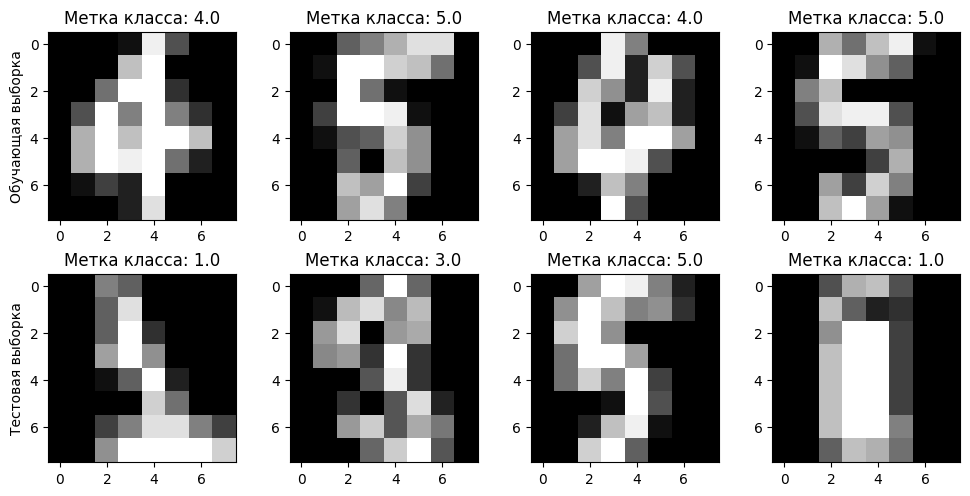

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for idx, ds in enumerate(((X_train, y_train), (X_test, y_test))):
    for jdx, kdx in enumerate(np.random.randint(0, len(ds[0]), size=4)):
        image, label = ds[0][kdx], ds[1][kdx]
        axes[idx, jdx].imshow(image.reshape([8, 8]).numpy(), cmap='gray')
        axes[idx, jdx].set_title(f'Метка класса: {label}')
        
axes[0, 0].set_ylabel('Обучающая выборка')
axes[1, 0].set_ylabel('Тестовая выборка')

#fig.text(
#    0.5, 0.5, 'Только для ознакомления', 
#    fontsize=40, color='gray', alpha=0.6,
#    ha='center', va='center', rotation='30'
#)

fig.tight_layout()
plt.show()

## Обучение нейронной сети.

Теперь всё готово к обучению нейронной сети. Для градиентной оптимизации в **Pytorch** реализовано множество оптимизаторов. В данном случае мы будем использовать оптимизатор **LBFGS** (класс `torch.optim.LBFGS`).

Большинство оптимизаторов в **Pytorch** отнаследовано от базового класса `torch.optim.Optimizer` и имеют следующий вид:
```python

class OptimizerExample(torch.optim.Optimizer):
    def __init__(self, params, **hyperparameters):
        '''
        Конструктор оптимизатора
        
        :param params: список или генератор обучаемых параметров модели
        :param hyperparameters: различные гиперпараметры оптимизатора, например, темп обучения
        '''
        super().__init__(params, hyperparameters)
    
        
    def step(self, closure=None):
        '''
        Функция, выполняющая шаг оптимизации, используя градиенты, сохранённые в тензорах self.params
        '''
        ...
        
    def zero_grad(self):
        '''
        Функция, очищающая градиенты, сохранённые в тензорах self.params
        '''
        ...
```

Создадим нейросеть, оптимизатор, а также класс-функцию потерь:

In [22]:
dense_network = DenseNetwork(
    in_features=in_features, hidden_size=hidden_size, 
    n_classes=n_classes, n_layers=3, activation=ReLU
)

# По умолчанию, LBFGS может делать несколько шагов оптимизации внутри себя. 
#   Чтобы ограничить это поведение, установим параметр max_iter равным 1
optimizer = torch.optim.LBFGS(dense_network.parameters(), max_iter=1)

loss_fn = CrossEntropyLoss()

In [23]:
dense_network, optimizer, loss_fn

(DenseNetwork(
   (layers): Sequential(
     (0): Linear(64, 32)
     (1): ReLU()
     (2): Linear(32, 32)
     (3): ReLU()
     (4): Linear(32, 10)
   )
 ),
 LBFGS (
 Parameter Group 0
     history_size: 100
     line_search_fn: None
     lr: 1
     max_eval: 1
     max_iter: 1
     tolerance_change: 1e-09
     tolerance_grad: 1e-07
 ),
 CrossEntropyLoss())

Одно из основных преимуществ **Pytorch** — возможность использовать графический ускоритель, что уменьшает время вычислений на порядки. При этом, Pytorch позволяет писать код таким образом, чтобы он запускался на любых устройствах, будь то CPU, или GPU, или TPU/XML (device-agnostic код). Для этого в Pytorch реализован класс-обёртка `torch.device`, содержащий информацию об устройстве, на котором будут происходить вычисления:

In [24]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 0)
    
print(type(device), device)

<class 'torch.device'> cpu


Для переноса всех параметров модели на нужное устройство можно использовать метод `to`:

In [25]:
dense_network.to(device), next(iter(dense_network.parameters()))

(DenseNetwork(
   (layers): Sequential(
     (0): Linear(64, 32)
     (1): ReLU()
     (2): Linear(32, 32)
     (3): ReLU()
     (4): Linear(32, 10)
   )
 ),
 Parameter containing:
 tensor([[ 0.0127, -0.0124,  0.0011,  ..., -0.0011,  0.0031, -0.0089],
         [-0.0124,  0.0089, -0.0037,  ...,  0.0026,  0.0132,  0.0243],
         [-0.0113,  0.0019,  0.0171,  ..., -0.0011, -0.0137, -0.0111],
         ...,
         [ 0.0021, -0.0211,  0.0063,  ...,  0.0061,  0.0029,  0.0022],
         [ 0.0098, -0.0107, -0.0104,  ..., -0.0104,  0.0293,  0.0114],
         [-0.0043, -0.0106, -0.0127,  ..., -0.0058, -0.0008, -0.0069]],
        requires_grad=True))

Теперь, осталось только реализовать цикл оптимизации и подсчёт метрик. 


Реализуем цикл обучения модели в функции `training_loop`:

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
import tqdm.notebook as tqdm

def training_loop(n_epochs, network, loss_fn, optimizer, ds_train, ds_test, device):
    '''
    :param int n_epochs: Число итераций оптимизации
    :param torch.nn.Module network: Нейронная сеть
    :param Callable loss_fn: Функция потерь
    :param torch.nn.Optimizer optimizer: Оптимизатор
    :param Tuple[torch.Tensor, torch.Tensor] ds_train: Признаки и метки истинного класса обучающей выборки
    :param Tuple[torch.Tensor, torch.Tensor] ds_test: Признаки и метки истинного класса тестовой выборки
    :param torch.Device device: Устройство на котором будут происходить вычисления
    :returns: Списки значений функции потерь и точности на обучающей и тестовой выборках после каждой итерации
    '''
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    for epoch in tqdm.tqdm(range(n_epochs), total=n_epochs, leave=True):
         # Переводим сеть в режим обучения
        network.train()

        # Итерация обучения сети
        def closure():
            '''
            Функция-замыкания для подсчёта градиентов функции потерь по обучающей выборке:
                1. Отчистка текущих градиентов
                2. Выполнение прямого прохода по сети в вычисление функции потерь
                3. Вычисление градиентов функции потерь
            :returns: Значение функции потерь
            '''
            optimizer.zero_grad()

            out = network(ds_train[0].to(device))
            curloss = loss_fn(out, ds_train[1].to(device).to(torch.long))
            train_losses.append(curloss.item())

            curloss.backward()

            return curloss.item()
        
        # Шаг оптимизации
        optimizer.step(closure)
        
        # Переводим сеть в инференс режим
        network.eval()

        # При тестировании сети нет необходимости считать градиенты, поэтому можно отключить автоматическое дифференцирование
        #   для ускорения операций
        with torch.no_grad():
            # Вычисление качества и функции потерь на обучающей выборке
            out = network(ds_train[0].to(device))
            curloss = loss_fn(out, ds_train[1].to(torch.long))
            train_losses.append(curloss.item())
            #curacc = torch.sum(out.argmax(axis=1)==ds_train[1])/ds_train[1].shape[0]
            #train_accuracies.append(curacc.detach())
            train_accuracies.append(accuracy_score(torch.argmax(out.cpu(), axis=1), ds_train[1]))

            
            # Вычисление качества и функции потерь на тестовой выборке
            out = network(ds_test[0].to(device))
            curloss = loss_fn(out, ds_test[1].to(torch.long))
            test_losses.append(curloss.item())
            #curacc = torch.sum(out.argmax(axis=1)==ds_test[1])/ds_test[1].shape[0]
            #test_accuracies.append(curacc.detach())
            test_accuracies.append(accuracy_score(torch.argmax(out.cpu(), axis=1), ds_test[1]))
            
            if epoch % 20 == 0:
                print(
                    'Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}'.format(
                        train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                    )
                )
            
    return train_losses, test_losses, train_accuracies, test_accuracies

Обучим сеть. Во всех экспериментах обучаем сеть $200$ эпох с параметром `max_iter=1` в оптимизаторе.

In [28]:
train_losses, test_losses, train_accs, test_accs = training_loop(
    n_epochs=200, network=dense_network, loss_fn=loss_fn, 
    optimizer=optimizer, ds_train=(X_train, y_train), ds_test=(X_test, y_test), device=device
)

  0%|          | 0/200 [00:00<?, ?it/s]

Loss (Train/Test): 2.302/2.303. Accuracy, % (Train/Test): 0.18/0.14
Loss (Train/Test): 0.870/1.043. Accuracy, % (Train/Test): 0.68/0.64
Loss (Train/Test): 0.170/0.336. Accuracy, % (Train/Test): 0.95/0.92
Loss (Train/Test): 0.007/0.586. Accuracy, % (Train/Test): 1.00/0.95
Loss (Train/Test): 0.000/3.020. Accuracy, % (Train/Test): 1.00/0.94
Loss (Train/Test): 0.000/3.138. Accuracy, % (Train/Test): 1.00/0.94
Loss (Train/Test): 0.000/3.138. Accuracy, % (Train/Test): 1.00/0.94
Loss (Train/Test): 0.000/3.138. Accuracy, % (Train/Test): 1.00/0.94
Loss (Train/Test): 0.000/3.138. Accuracy, % (Train/Test): 1.00/0.94
Loss (Train/Test): 0.000/3.138. Accuracy, % (Train/Test): 1.00/0.94


Выведем итоговое качество и значение функции потерь на обучении (`X_train`, `y_train`) и на контроле (`X_test`, `y_test`):

In [29]:
print(f'Cross Entropy (Train/Test): {train_losses[-1]}/{test_losses[-1]}')
print(f'Accuracy (Train/Test): {train_accs[-1]}/{test_accs[-1]}')

Cross Entropy (Train/Test): 2.477995364458252e-09/3.1381723880767822
Accuracy (Train/Test): 1.0/0.9422222222222222


Изобразим на графике кривую качества на обучении и контроле по итерациям:

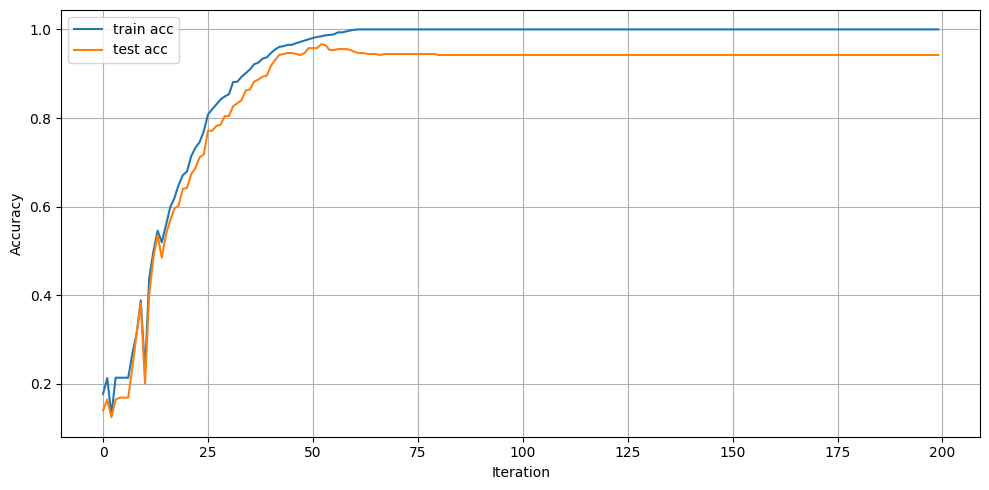

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_accs, label="train acc")
ax.plot(test_accs, label="test acc")
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")
ax.grid(True)
ax.legend()

#fig.text(
#    0.5, 0.5, 'Только для ознакомления', 
#    fontsize=40, color='gray', alpha=0.6,
#    ha='center', va='center', rotation='30'
#)

fig.tight_layout()
plt.show()